In [10]:
import numpy as np
import scipy as sp
import scipy.stats as sps
import numba
import pymc as pm
import matplotlib.pyplot as plt

# 1

In [11]:
def generate(n: int, gamma: float = 42) -> np.array:
    return sps.cauchy(loc=0, scale=gamma).rvs(n)

def generate_scaled(n: int, gamma: float = 42, sigma: float = 1.337) -> np.array:
    return sps.cauchy(loc=0, scale=gamma*sigma).rvs(n)

In [12]:
def sigma(): 
    x1 = generate(10**6)
    x2 = generate_scaled(10**6)
    
    x1_median = np.median(x1)

    x2_median = np.median(x2)
    
    return x2_median / x1_median

# 2

In [13]:
def weighted_corr(sample: np.array, weights: np.array) -> float:
    x = sample[:, 0]
    y = sample[:, 1]
    
    x_mean = np.sum(weights * x)
    y_mean = np.sum(weights * y)
    
    x_var = np.sum(weights * x**2) - x_mean**2
    y_var = np.sum(weights * y**2) - y_mean**2
    
    return np.sum(weights * (x - x_mean) * (y - y_mean)) / np.sqrt(x_var * y_var)

# 3

In [14]:
data = [28, 26, 33, 24, 34, -44, 27, 16, 40, -2, 29,
        22, 24, 21, 25, 30, 23, 29, 31, 19, 24, 20,
        36, 32, 36, 28, 25, 21, 28, 29, 37, 25, 28,
        26, 30, 32, 36, 26, 30, 22, 36, 23, 27, 27,
        28, 27, 31, 27, 26, 33, 26, 32, 32, 24, 39,
        28, 24, 25, 32, 25, 29, 27, 28, 29, 16, 23]

In [ ]:
n_samples = 10**8
n = len(data)
s2 = np.var(data, ddof=1)

sigma2 = (n - 1) * s2 / sps.chi2(df=n-1).rvs(n_samples)
mu = sps.norm(loc=np.mean(data), scale=np.sqrt(sigma2/n)).rvs(n_samples)

In [16]:
np.quantile(mu, q=[0.025, 0.975])

array([23.5709279 , 28.85384027])

In [17]:
with pm.Model() as model:
    sigma2 = (n - 1) * s2 / pm.ChiSquared('chi2', nu=n-1)
    mu = pm.Normal('mu', mu=np.mean(data), sigma=pm.math.sqrt(sigma2))

    pm.Normal("likelihood", mu=mu, sigma=pm.math.sqrt(sigma2), observed=data)

    trace = pm.sample(draws=10**5, nuts_sampler='numpyro')


mu_samples = trace.posterior["mu"].values.flatten()
lower = np.quantile(mu_samples, 0.025)
upper = np.quantile(mu_samples, 0.975)

print(f"{lower:.2f} {upper:.2f}")

  0%|          | 0/101000 [00:00<?, ?it/s]

  0%|          | 0/101000 [00:00<?, ?it/s]

  0%|          | 0/101000 [00:00<?, ?it/s]

  0%|          | 0/101000 [00:00<?, ?it/s]

23.62 28.80


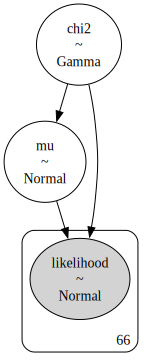

In [9]:
pm.model_to_graphviz(model)

# 4

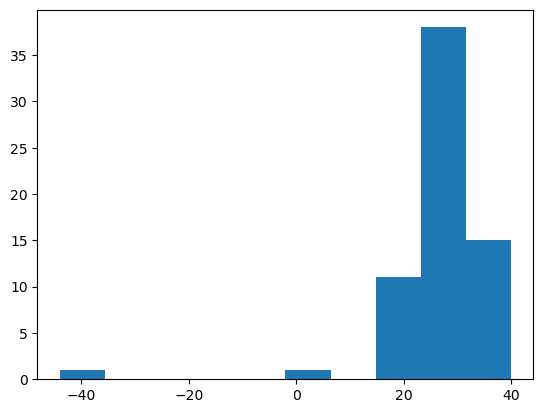

In [11]:
plt.hist(data)
plt.show()

In [101]:
# with pm.Model() as model:
#     sigma2 = (len(data) - 1) * s2 / pm.ChiSquared('chi2', nu=n-1)
#     mu = pm.Normal('mu', mu=np.mean(data), sigma=pm.math.sqrt(sigma2))

#     likelihood = pm.Normal("likelihood", mu=mu, sigma=pm.math.sqrt(sigma2), observed=data)
    
#     min_data = pm.Deterministic('min_data', pm.math.min(likelihood,-1))

#     trace = pm.sample(draws=10**3, nuts_sampler='numpyro')
    
#     min_data_posterior_predictive = pm.sample_posterior_predictive(trace, var_names=["min_data"])

In [100]:
# pm.model_to_graphviz(model)

In [73]:
n_samples = 10**5
n = len(data)
s2 = np.var(data, ddof=1)

sigma2 = (n - 1) * s2 / sps.chi2(df=n-1).rvs(n_samples)
mu = sps.norm(loc=np.mean(data), scale=np.sqrt(sigma2/n)).rvs(n_samples)
data_samples = sps.norm(loc=mu, scale=np.sqrt(sigma2)).rvs((n, n_samples))
np.quantile(data_samples.min(0), [0.025, 0.975])

array([-11.85861864,   9.92425691])

# 5

In [102]:
120 * 8419 * 9161

9255175080

In [98]:
import scipy.stats as sps

def solution(a, b, c, d, t_curr, t1):
    tau = t_curr - t1 

    marg_active = (b / (a + b)) * (d / (d + tau)) ** c
    marg_churned = a / (a + b)
    total_marginal = marg_active + marg_churned
    
    w = marg_active / total_marginal
    
    def posterior_density(p, q):
        active_p = sps.beta.pdf(p, a, b + 1)
        active_q = sps.gamma.pdf(q, c, scale=1/(d + tau))
        
        churned_p = sps.beta.pdf(p, a + 1, b)
        churned_q = sps.gamma.pdf(q, c, scale=1/d)
        
        return w * active_p * active_q + (1 - w) * churned_p * churned_q
    
    return posterior_density

In [99]:
print(solution(2, 20, 2, 2, 0, -3)(0.1, 1))

1.8816592254887186
